In [1]:
# Generalised model set up that allows passing of arbitrary model for fitting, 
# hyperparameters can specified as values = [_v1,_v2,...,_vn] for discrete and bounds = [_lower,_upper] for continuous


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# --------------------------
# Bayesian Optimisation Code
# --------------------------

from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern,RBF
from scipy.optimize import minimize
from pyDOE import *

# -----------------------------------------
# --- Class for a continuous hyperparameter
# -----------------------------------------
    
# --- Define a hyperparameter class that contains all the required specs of the hyperparameter
class hyperparam(object):
    
    def __init__(self,list_in):
        
        # Initiate with 2 types of variable. We either specify bounds
        # for continuous variable or values for discrete. Note that for
        # now the values must be integers and be a list of consecutive
        # integers.
        if len(list_in) == 2:
            self.bounds = list_in
            self.kind = 'continuous'
        elif len(list_in) > 2:
            self.bounds = [list_in[0],list_in[-1]]
            self.kind = 'discrete'
            self.vals = list_in
        

        
        
        
        
        
        
        
class iteration(object):
    
    def __init__(self,pars):
        
        
#         # --- Sample data
        self.Xt = pars.Xt
        self.Yt = pars.Yt
       
        # Obtain next sampling point from the acquisition function (expected_improvement)
        X_next = self.propose_location(pars)
        # Convert to int where necessary
        
        # We need to recreate a dictionary with the keys given by the hyperparameter name before pasing into our
        # ML model
        self.X_nextdict = {}
        for i,hps1 in enumerate(sorted(pars.Xtdict.keys())):
            if pars.hps[hps1].kind == 'discrete':
                X_next[i] = int(X_next[i])
                self.X_nextdict[hps1] = X_next[i]
            else:
                self.X_nextdict[hps1] = X_next[i]
        
        #X_next = np.array(X_next,ndmin=(2)).reshape(1,-1)
        Y_next = pars.objF(self.X_nextdict)
        
        # Add the new sample point to the existing for the next iteration
        self.Xt = np.vstack((self.Xt, X_next.reshape(1,-1)[0]))
        self.Yt = np.concatenate((self.Yt, Y_next))
    
    # Sampling function to find the next values for the hyperparameters
    def propose_location(self,pars):
        
        # Proposes the next sampling point by optimizing the acquisition function. Args: acquisition: Acquisition function. X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. Returns: Location of the acquisition function maximum. '''
        self.N_hps = pars.Xt.shape[1]
        min_val = 1
        min_x = None

        self.gpr = pars.gpr
        self.Xt = pars.Xt
    


        # Find the best optimum by starting from n_restart different random points.
        Xs = lhs(self.N_hps, samples=pars.n_restarts, criterion='centermaximin')
        for i,hp in enumerate(sorted(pars.hps.keys())):
            Xs[:,i] = Xs[:,i]*(pars.hps[hp].bounds[1]-pars.hps[hp].bounds[0])+pars.hps[hp].bounds[0]
        
            # Convert int values to integers
            if pars.hps[hp].kind == 'discrete':
                Xs[:,i] = Xs[:,i].astype(int)
        
        # Find the maximum in the acquisition function
        if pars.optim_rout == 'minimize':
            for x0 in Xs:
                res = minimize(self.min_obj, x0=x0, bounds=pars.bounds, method=pars.method) 
                # Find the best optimum across all initiations
                if res.fun < min_val:
                    min_val = res.fun[0]
                    min_x = res.x   
                    
        elif pars.optim_rout == 'MCMC-MH':
            for x0 in Xs:
                res_x,res_f = self.MetroHastings(x0,[0.1]*self.N_hps,10000,tuple(pars.bounds))
                if res_f < min_val:
                    min_val = res_f
                    min_x = res_x
                    
        elif pars.optim_rout == 'MCMC-discrete':
            for x0 in Xs:
                res_x,res_f = self.discrete_MCMC(x0,pars.x_dict,10000)
                if res_f < min_val:
                    min_val = res_f
                    min_x = res_x

        return min_x.reshape(-1, 1)
    
    def min_obj(self,X):
    # Minimization objective is the negative acquisition function
        return -self.expected_improvement(X.reshape(-1, self.N_hps))
    
    def max_obj(self,X):
    # Minimization objective is the negative acquisition function
        return self.expected_improvement(X.reshape(-1, self.N_hps))
        
    # Acquisition function - here we use expected improvement
    def expected_improvement(self,X):
        
        # --- Computes the EI at points X based on existing samples X_sample and Y_sample using a Gaussian process 
        # surrogate model. 
        # X: Points at which EI shall be computed (m x d). 
        # X_sample: Sample locations (n x d). 
        # Y_sample: Sample values (n x 1). 
        # gpr: A GaussianProcessRegressor fitted to samples. 
        # xi: Exploitation-exploration trade-off parameter. 
        #.   - xi ~ O(0) => exploitation
        #.   - xi ~ O(1) => exploration
        # Returns: Expected improvements at points X.

        # Evaluate the Gaussian Process at a test location X to get the mean and std
        mu, sigma = self.gpr.predict(X, return_std=True)
        # Evaluate the Gaussian Process at the sampled points - this gets the mean values without the noise
        mu_sample = self.gpr.predict(self.Xt)

        
        sigma = sigma.reshape(-1, 1)#self.Xt.shape[1])

        # Needed for noise-based model,
        # otherwise use np.max(Y_sample).
        # See also section 2.4 in [...]
        mu_sample_opt = np.max(mu_sample)

        imp = mu - mu_sample_opt
        Z = imp / sigma

        Ei = (mu-mu_sample_opt) * norm.cdf(mu,loc=mu_sample_opt, scale=sigma) \
            + mu_sample_opt * norm.pdf(mu,loc=mu_sample_opt, scale=sigma)


        return Ei
    
    def MetroHastings(self,x0,sig,Niter,bounds):
    
        "Function to perform metropolis Hastings sampling in an MCMC"

        # --- Input ---
        # x0: initial guess for random walk - list of continuous variables
        # sig is the uncertainty in the MH sampling algorithm
        # Niter is number of iterations to perform
        # bounds: list of tuples of length x0, each one being the lower and upper bounds 

        # --- Output ---
        # Modal solution from the MCMC

        # Calculate initial guess
        acq = np.zeros(Niter)
        acq[0] = self.min_obj(x0.reshape(1,-1))

        # proposition point
        xp = np.zeros((len(x0),Niter))
        xp[:,0] = x0

        for iiter in range(1,Niter):

            # Propose new data point to try using MH
            for i in range(len(x0)):

                # iterate until we get a point in the correct interval
                if x0[i]<bounds[i][0]:
                    loc0 = bounds[i][0]
                elif x0[i]>bounds[i][1]:
                    loc0 = bounds[i][1]
                else:
                    loc0 = x0[i]

                Pnext = np.random.normal(loc=loc0,scale=sig[i])
                while (Pnext < bounds[i][0]) | (Pnext >= bounds[i][1]):
                    Pnext = np.random.normal(loc=loc0,scale=sig[i])

                # Then choose the first point that is    
                xp[i,iiter] = Pnext

            # Test value at this point
            acq[iiter] = self.min_obj(xp[:,iiter].reshape(1,-1))

            # Check if proposed point is better
            if acq[iiter] > acq[iiter-1]:
                x0 = xp[:,iiter].copy()

            else:
                p0 = [acq[iiter-1]/(acq[iiter]+acq[iiter-1]),acq[iiter]/(acq[iiter]+acq[iiter-1])]
                nextP = np.random.choice([0,1],p=p0)

                if nextP == 1:
                    x0 = xp[:,iiter].copy()
                else:
                    x0 = xp[:,iiter-1].copy()
                    
            
        # Now get optimal solution by fitting a histogram to the data - ignore first 10% of samples
        optim_x = np.zeros((1,len(x0)))   
        for i in range(optim_x.shape[1]):
            optim_x[0,i] = kernel_density_estimation(xp[i,int(0.1*Niter):],Niter)

        return optim_x,self.min_obj(optim_x.reshape(1,-1))

    def kernel_density_estimation(self,xpi,Niter):

        " Function to find peak in a kernel density "

        # We initially fudge this to get it working! 
        # So we fit a histogram and then find the middle of the tallest bar

        # Fit a histogram
        data = xpi.copy()
        data.sort()
        hist, bin_edges = np.histogram(data, density=True,bins=max(10,30))

        # Return the middle of the largest bin
        n = np.argmax(hist)
        return np.mean(bin_edges[n:n+2])
    
    def discrete_MCMC(self,x0,x_dict,Niter):

        "Function to perform fully discrete metropolis Hastings sampled MCMC"

        # --- Input ---
        # x0: starting guess
        # Niter is number of iterations to perform
        # bounds: dictionary of values for each variable with key equal to the position in the array 

        # --- Output ---
        # Modal solution from the MCMC

        # Calculate initial guess
        acq = np.zeros(Niter)
        acq[0] = acquisition_function(np.array(x0).reshape(1,-1))

        # proposition point
        xp = np.zeros((len(x0),Niter))
        xp[:,0] = x0

        # count frequency of each value appearing
        N_dict = {}
        for k1 in x_dict.keys():
            N_dict[k1] = np.zeros(len(x_dict[k1]))

        for iiter in range(1,Niter):

            # Choose a location to swap
            i_choice = np.random.choice(range(len(x0)))

            # Set xp to be x0
            xp[:,iiter] = x0.copy()
            # choose a new value for the i_choice-th entry
            xp[i_choice,iiter] = np.random.choice(x_dict[i_choice])

            # Test value at this point
            acq[iiter] = acquisition_function(xp[:,iiter].reshape(1,-1))

            # Check if proposed point is better
            if acq[iiter] > acq[iiter-1]:
                x0 = xp[:,iiter].copy()

            else:
                p0 = [acq[iiter-1]/(acq[iiter]+acq[iiter-1]),acq[iiter]/(acq[iiter]+acq[iiter-1])]
                nextP = np.random.choice([0,1],p=p0)
                if nextP == 1:
                    x0 = xp[:,iiter].copy()
                else:
                    x0 = xp[:,iiter-1].copy()

            # accumulate the counts - when iiter excedes a 10th of Niter
            if iiter > 0.1*Niter:
                for aci in range(len(x0)):
                    N_dict[aci][x_dict[aci].index(x0[aci])] += 1

        # Now get optimal solution by fitting a histogram to the data - already ignored first 10% of samples
        optim_x = np.zeros((1,len(x0)))   
        for i in range(len(x0)):
            optim_x[0,i] = x_dict[i][np.argmax(N_dict[i])]

        return optim_x,acquisition_function(optim_x[0,:].reshape(1,-1))
    
    
    
class BayesianOptimisation(object):
    
    def __init__(self,**kwargs):
        
        # Get hyperparameter info and convert to hyperparameter class
        self.hps = {}
        for hp in kwargs['hps'].keys():
            self.hps[hp] = hyperparam(kwargs['hps'][hp])
        
        # Objective function to minimise
        self.MLmodel = kwargs['MLmodel']
        
            
        # Number of hyperparameters
        N_hps = len(self.hps.keys())
        
        # --- Initial sample data
        if 'NpI' in kwargs.keys():
            self.NpI = kwargs['NpI']
        else:
            self.NpI = 2**N_hps
            
        # --- Optimisation routine for the acquisition function
        if 'optim_rout' in kwargs.keys():
            self.optim_rout = kwargs['optim_rout']
            # Now define a new dictionary for use in discrete MCMC optimisation
            if self.optim_rout == 'MCMC-discrete':
                self.x_dict = {}
                for i,hp in enumerate(self.hps.keys()):
                    self.x_dict[i] = list(self.hps[hp].vals)
        else:
            self.optim_rout = 'minimize'
        
        
        # Establish a dictionary for our hyperparameter values that we sample
        self.Xtdict = {}
        # ...and then an array for the same thing but with each column being
        # a different hyperparameter and ordered alphabetically
        self.Xt = np.zeros((self.NpI,len(self.hps.keys())))
        # We also need to collect together all of the bounds for the optimization routing into one array
        self.bounds = np.zeros((2,len(self.hps.keys())))
        
        # Get some initial samples on the unit interval
        Xt = lhs(len(self.hps.keys()), samples=self.NpI, criterion='centermaximin')
        
        # For each hyper parameter, rescale the unit inverval on the 
        # appropriate range for that hp and store in a dict
        for i,hp in enumerate(sorted(self.hps.keys())):
            self.Xtdict[hp] = self.hps[hp].bounds[0]+Xt[:,i]*(self.hps[hp].bounds[1]-self.hps[hp].bounds[0])
            # convert these to an int if kind = 'discrete'
            
            if self.hps[hp].kind == 'discrete':
                self.Xtdict[hp] = self.Xtdict[hp].astype(int)
            
            self.bounds[i,:] = self.hps[hp].bounds

            self.Xt[:,i] = self.Xtdict[hp]
    

        
            
        # Calculate objective function at the sampled points
        self.Yt = self.objF(pars=self.Xtdict,n=self.NpI)

        
        
        # --- Number of iterations
        if 'Niter' in kwargs.keys():
            self.Niter = kwargs['Niter']
        else:
            self.Niter = 10*N_hps
            
        # --- Number of optimisations of the acquisition function
        if 'n_restarts' in kwargs.keys():
            self.n_restarts = kwargs['n_restarts']
        else:
            self.n_restarts = 25*N_hps
            
        # --- Optimisation method used
        if 'method' in kwargs.keys():
            self.method = kwargs['method']
        else:
            self.method = 'L-BFGS-B'
            
        
        # --- Define the Gaussian mixture model
        if 'kernel' in kwargs.keys():
            self.kernel = kwargs['kernel']
        else:
            self.kernel = RBF()
            
        if 'noise' in kwargs.keys():
            self.noise = kwargs['noise']
        else:
            self.noise = noise = 0.2
            
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, alpha=noise**2)
        
    def optimise(self):
        for i in range(self.Niter):
            it1 = iteration(self)
            self.Xt = it1.Xt
            self.Yt = it1.Yt
            if i == 0:
                print self.Yt
            print('current accuracy:',self.Yt[-1])
            print('best accuracy:', max(self.Yt))
            self.gpr.fit(self.Xt, self.Yt)
        return self
    
    def objF(self,pars,**kwargs):
        
        # Number of hyperparameter values to try. 
        n = 1
        if 'n' in kwargs.keys():
            n = kwargs['n']

        # Initiate array to accumate the accuracy of the model
        sc = np.zeros(n)
        
        # Establish the basic ML model
        model = self.MLmodel
        
        for i in range(n):
            
            # Get dictionary of hyperparameter values to test at the ith iteration
            hps_iter = {}
            for hp in pars.keys():
                if self.hps[hp].kind == 'discrete':
                    hps_iter[hp] = int(pars[hp][i])
                else:
                    hps_iter[hp] = pars[hp][i]
                
            # Create instance of MLmodel with the hps at this iteration
            model.set_params(**hps_iter)
        
            # Train
            model.fit(X_train,y_train)
            
            # Score
            sc[i] = np.mean(cross_val_score(model, X_train,y_train, cv=5))
            
        return sc

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X_train = 15*np.random.uniform(size=(100,2))

y_train = np.zeros((100,1))
for i in range(X_train.shape[0]):
    y_train[i] = 1-acquisition_function(X_train[i,:].reshape(1,-1))
y_train = y_train+0.1*np.random.uniform(size=(100,1))
y_train = y_train.ravel()
y_train
hps_rf = {
    'n_estimators':range(1,10),
    'max_depth':range(1,10)
}
BOout = BayesianOptimisation(
    hps=hps_rf,
    MLmodel = RandomForestRegressor(random_state= 42),
    optim_rout = 'MCMC-discrete',
    NpI = 2,
    Niter = 50
).optimise()

[0.87711999 0.90029938 0.89510659]
('current accuracy:', 0.8951065854962058)
('best accuracy:', 0.9002993784579413)
('current accuracy:', 0.9116148664683935)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.9092572842858029)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.8951065854962058)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.9053179369335176)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.9116148664683935)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.8783798988365522)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.8959732467662093)
('best accuracy:', 0.9116148664683935)
('current accuracy:', 0.9138766177057092)
('best accuracy:', 0.9138766177057092)
('current accuracy:', 0.8783798988365522)
('best accuracy:', 0.9138766177057092)
('current accuracy:', 0.9192916532505733)
('best accuracy:', 0.9192916532505733)
('current accuracy:', 0.9055688408812221)
('best accuracy:', 0.91929165325

In [62]:
best_params = BOout.Xt[np.argmax(BOout.Yt)]
RFr = RandomForestRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    random_state=42
).fit(X_train,y_train)
np.mean(cross_val_score(RFr, X_train,y_train, cv=5))

0.9192916532505733

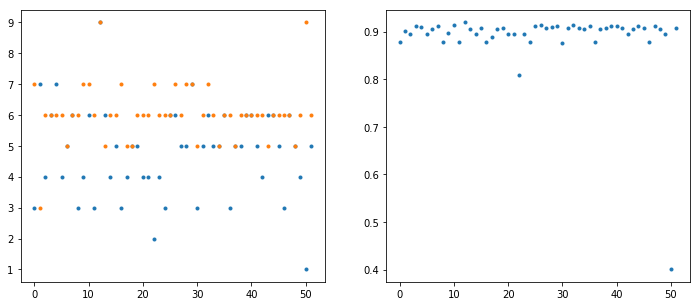

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

# Simple 2d gaussian acquisition function - update using MH

In [6]:
def acquisition_function(z):
    x=z[0,0]
    y=z[0,1]
    return np.exp(-((x-5)/10)**2)*np.exp(-((y-10)/10)**2)

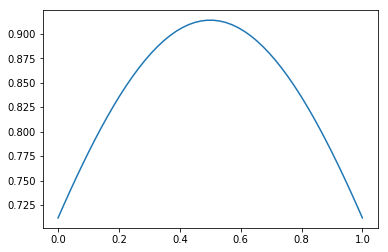

In [14]:

plt.plot(np.linspace(0,1),acquisition_function(np.linspace(0,1),0.2))

In [642]:
def MetroHastings(x0,optim_func,sig,Niter,bounds):
    
    "Function to perform metropolis Hastings sampling in an MCMC"
    
    # --- Input ---
    # x0: initial guess for random walk - list of continuous variables
    # sig is the uncertainty in the MH sampling algorithm
    # Niter is number of iterations to perform
    # bounds: list of tuples of length x0, each one being the lower and upper bounds 
    
    # --- Output ---
    # Modal solution from the MCMC
    
    # Calculate initial guess
    acq = np.zeros(Niter)
    acq[0] = acquisition_function(x0[0],x0[1])
    
    # proposition point
    xp = np.zeros((len(x0),Niter))
    xp[:,0] = x0
    
    for iiter in range(1,Niter):
        
        # Propose new data point to try using MH
        for i in range(len(x0)):
            
            # iterate until we get a point in the correct interval
            if x0[i]<bounds[i][0]:
                loc0 = bounds[i][0]
            elif x0[i]>bounds[i][1]:
                loc0 = bounds[i][1]
            else:
                loc0 = x0[i]
            
            Pnext = np.random.normal(loc=loc0,scale=sig[i])
            while (Pnext < bounds[i][0]) | (Pnext >= bounds[i][1]):
                Pnext = np.random.normal(loc=loc0,scale=sig[i])
                
            # Then choose the first point that is    
            xp[i,iiter] = Pnext
            
        # Test value at this point
        acq[iiter] = acquisition_function(xp[0,iiter],xp[1,iiter])
        
        # Check if proposed point is better
        if acq[iiter] > acq[iiter-1]:
            x0 = xp[:,iiter].copy()
        
        else:
            p0 = [acq[iiter-1]/(acq[iiter]+acq[iiter-1]),acq[iiter]/(acq[iiter]+acq[iiter-1])]
            nextP = np.random.choice([0,1],p=p0)
            if nextP == 1:
                x0 = xp[:,iiter].copy()
            else:
                x0 = xp[:,iiter-1].copy()
  
    # Now get optimal solution by fitting a histogram to the data
    optim_x = np.zeros((1,len(x0)))   
    for i in range(optim_x.shape[1]):
        optim_x[0,i] = kernel_density_estimation(xp[i,int(0.1*Niter):],Niter)
        
    return optim_x,acquisition_function(optim_x[0,0],optim_x[0,1])
    
def kernel_density_estimation(xpi,Niter):
    
    " Function to peak in a kernel density "
    
    # We initially fudge this to get it working!
    
    # Fit a histogram
    data = xpi.copy()
    data.sort()
    hist, bin_edges = np.histogram(data, density=True,bins=max(10,30))
    
    # Return the largest bin
    n = np.argmax(hist)
    return np.mean(bin_edges[n:n+2])

In [701]:
def discrete_MCMC(x0,x_dict,Niter):

    "Function to perform fully discrete metropolis Hastings sampled MCMC"
    
    # --- Input ---
    # x0: starting guess
    # Niter is number of iterations to perform
    # bounds: dictionary of values for each variable with key equal to the position in the array 
    
    # --- Output ---
    # Modal solution from the MCMC
    
    # Calculate initial guess
    acq = np.zeros(Niter)
    acq[0] = acquisition_function(np.array(x0).reshape(1,-1))
    
    # proposition point
    xp = np.zeros((len(x0),Niter))
    xp[:,0] = x0
    
    # count frequency of each value appearing
    N_dict = {}
    for k1 in x_dict.keys():
        N_dict[k1] = np.zeros(len(x_dict[k1]))
    
    for iiter in range(1,Niter):
        
        # Choose a location to swap
        i_choice = np.random.choice(range(len(x0)))
            
        # Set xp to be x0
        xp[:,iiter] = x0.copy()
        # choose a new value for the i_choice-th entry
        xp[i_choice,iiter] = np.random.choice(x_dict[i_choice])
                    
        # Test value at this point
        acq[iiter] = acquisition_function(xp[:,iiter].reshape(1,-1))
        
        # Check if proposed point is better
        if acq[iiter] > acq[iiter-1]:
            x0 = xp[:,iiter].copy()
        
        else:
            p0 = [acq[iiter-1]/(acq[iiter]+acq[iiter-1]),acq[iiter]/(acq[iiter]+acq[iiter-1])]
            nextP = np.random.choice([0,1],p=p0)
            if nextP == 1:
                x0 = xp[:,iiter].copy()
            else:
                x0 = xp[:,iiter-1].copy()
                
        # accumulate the counts - when iiter excedes a 10th of Niter
        if iiter > 0.1*Niter:
            for aci in range(len(x0)):
                N_dict[aci][x_dict[aci].index(x0[aci])] += 1
  
    # Now get optimal solution by fitting a histogram to the data
    optim_x = np.zeros((1,len(x0)))   
    for i in range(len(x0)):
        optim_x[0,i] = x_dict[i][np.argmax(N_dict[i])]
        
    return optim_x,acquisition_function(optim_x[0,:].reshape(1,-1))

In [702]:
x_dict = {}
x_dict[0] = range(1,11)
x_dict[1] = range(1,21)

In [709]:
Niter = 20000
guess = np.array([
    np.random.choice(x_dict[0]),
    np.random.choice(x_dict[1])
])
optim_x,optim_f = discrete_MCMC(guess,x_dict,Niter)

In [710]:
N_dict

{0: array([1420., 1782., 2190., 2550., 2735., 2621., 2158., 1866., 1477.,
        1200.]),
 1: array([ 453.,  621.,  604.,  906., 1021., 1124., 1249., 1496., 1634.,
        1611., 1459., 1471., 1223., 1211., 1082.,  814.,  612.,  552.,
         435.,  421.])}

In [711]:
optim_x

array([[ 5., 11.]])

In [691]:
optim_f

0.9900498337491681

In [552]:
Niter = 10000
optim_x,optim_f = MetroHastings([0.1,0.4],acquisition_function,[0.1,0.1],Niter,[(0,1),(0,1)])

[0.25726713 0.11055226] 0.9978963279681208


In [542]:
optim_x,optim_f

(array([[0.45029057, 0.48329823]]), 0.9972538008560716)

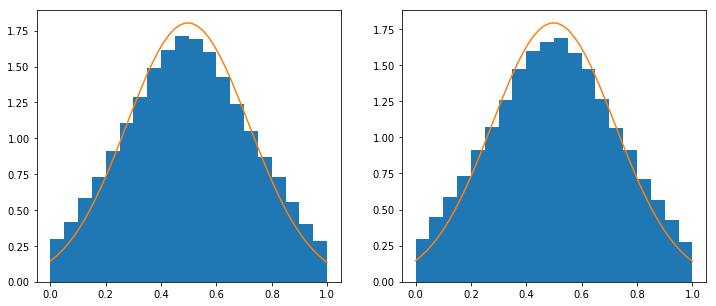

In [474]:
from scipy.stats import norm

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(xp[0],normed=True,bins=max(10,20))

mu, std = norm.fit(xp[0])
xlin = np.linspace(0,1)
plt.plot(xlin,norm.pdf(xlin, mu, std))


plt.subplot(122)
plt.hist(xp[1],normed=True,bins=max(10,20))

mu, std = norm.fit(xp[1])
xlin = np.linspace(0,1)
plt.plot(xlin,norm.pdf(xlin, mu, std))

plt.show()

In [475]:
optim_x

array([[0.48339815, 0.51669011]])

In [476]:
optim_x = np.zeros((1,len(x0)))   
for i in range(len(optim_x)):
    # Fit a normal

    # Save the mean - ie highest density of points
    optim_x[i] = kernel_density_estimation(xp[i,:])

TypeError: kernel_density_estimation() takes exactly 2 arguments (1 given)

In [221]:
xp[i]

array([0.1       , 0.01190927, 0.12435207, ..., 0.22757897, 0.25576384,
       0.25381378])

In [183]:
data = xp[0].copy()
data.sort()

In [258]:
hist, bin_edges = np.histogram(data, density=True,bins=int(Niter/100))
#hist, bin_edges = np.histogram(data, density=True,bins=bin_edges)

In [260]:
len(bin_edges)

101

In [157]:
Niter = 10000
Niter/(100.)

100.0

In [593]:
len(np.zeros((1,4)))

1

In [712]:
import BayesianHyperparameter3

SyntaxError: Non-ASCII character '\xc2' in file BayesianHyperparameter3.py on line 23, but no encoding declared; see http://www.python.org/peps/pep-0263.html for details (BayesianHyperparameter3.py, line 23)